In [ ]:
import cv2
import json
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers.optimization import get_scheduler
from transformers import CLIPModel, BertTokenizer, GPT2LMHeadModel, GPT2Model, CLIPFeatureExtractor, CLIPVisionModel, logging, AdamW

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 加载GPT2预训练模型

In [ ]:
logging.set_verbosity_error()   # 消除未使用权重的warning

text_model = GPT2Model.from_pretrained("uer/gpt2-chinese-cluecorpussmall").to(device)
# 冻结参数
# 不训练, 不需要计算梯度
# for param in text_model.parameters():
    # param.requires_grad = False

In [ ]:
tokenizer = BertTokenizer.from_pretrained("uer/gpt2-chinese-cluecorpussmall")

### 加载数据集

In [ ]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, data_path, cap_path, tokenizer):
        dataset = torch.load(data_path)
        caption = json.load(open(cap_path))
        self.data = {'img_feature': [], 'label': []}

        for cap in caption:
            if(dataset.get(cap['image_id']) is None):
                continue
            self.data['img_feature'].append(dataset[cap['image_id']])
            label = tokenizer.batch_encode_plus(cap['caption'], return_tensors='pt', return_token_type_ids=False, add_special_tokens=True, padding='max_length', max_length=32, truncation=True)
            self.data['label'].append(label)

        self.data['img_feature'] = torch.concat(self.data['img_feature'])

    def __getitem__(self, idx):
        # 随机选择与一个caption
        label_id = np.random.randint(0, 1)

        img_feature = self.data['img_feature'][idx]
        label_ids = self.data['label'][idx]['input_ids'][label_id, 1:]
        label_attention_mask = self.data['label'][idx]['attention_mask'][label_id, 1:]

        return {'img_feature': img_feature, 'label_ids': label_ids, 'label_attention_mask': label_attention_mask}
    
    def __len__(self):
        return self.data['img_feature'].shape[0]

In [ ]:
dataset = DataSet('./test_emb.pt', './images/im_cap/caption_validation_annotations.json', tokenizer)

loader = torch.utils.data.DataLoader(
    dataset = dataset, 
    batch_size = 8, 
    shuffle = True,
    drop_last = True
)
for i in loader:
    print(i['img_feature'].shape, i['label_ids'].shape, i['label_attention_mask'].shape)
    break
print(i['img_feature'], i['label_ids'], i['label_attention_mask'])

In [ ]:
js = json.load(open('./images/im_cap/caption_validation_annotations.json'))
js

### 定义模型

In [61]:
# 定义下游任务模型
class Model(torch.nn.Module):
    def __init__(self, gpt: GPT2Model, prefix_len, const_len):
        super().__init__()
        self.device = device
        self.prefix_len = prefix_len
        self.const_len = const_len
        # self.const_embeddings = torch.nn.Parameter(torch.randn(1, const_len, 768))

        self.mapping_vision = torch.nn.Sequential(torch.nn.Linear(1024, prefix_len*768))
        # self.mapping_prefix = torch.nn.Linear(768, 768)
        self.text_gen = gpt
        # 加载生成模型生成部分最后一层fc参数
        self.fc = torch.nn.Linear(768, tokenizer.vocab_size, bias=False).to(self.device)
        parameters = GPT2LMHeadModel.from_pretrained('uer/gpt2-chinese-cluecorpussmall').to(self.device)
        self.fc.load_state_dict(parameters.lm_head.state_dict())

        self.criterion =torch.nn.CrossEntropyLoss().to(self.device)

    def forward(self, img_feature, label_ids, label_attention_mask):
        bs = img_feature.shape[0]

        # 将图像特征map到文本特征
        prefix_embeddings = self.mapping_vision(img_feature).view(bs, self.prefix_len, 768)
        # prefix_embeddings = torch.concat([prefix_embeddings, self.const_embeddings.expand(bs, self.const_len, 768)], dim=1)
        # prefix_embeddings = self.mapping_prefix(prefix_embeddings)
        label_embeddings = self.text_gen.wte(label_ids)
        
        # 文本生成
        logits = torch.concat([prefix_embeddings, label_embeddings], dim=1)
        prefix_mask = torch.ones(bs, self.prefix_len+self.const_len).to(self.device)
        attention_mask = torch.concat([prefix_mask, label_attention_mask], dim=1)   # 补齐mask
    
        logits = self.text_gen(inputs_embeds=logits, attention_mask=attention_mask).last_hidden_state
        logits = self.fc(logits)

        # 取有效值算loss
        loss_mask_head = torch.zeros(bs, self.prefix_len+self.const_len-1).to(self.device)
        loss_mask_tail = torch.zeros(bs, 1).to(self.device)
        loss_mask = torch.concat([loss_mask_head, label_attention_mask, loss_mask_tail], dim=1)
        # 计算损失
        shift_logits = logits[loss_mask == 1]
        shift_labels = label_ids[label_attention_mask == 1]

        loss = self.criterion(shift_logits, shift_labels)

        return {
            'loss': loss,
            'logits': logits
        }

In [ ]:
model = Model(text_model, 2, 0).to(device)

# 训练

In [ ]:
def train(model, epoches):
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr = 1e-4)
    # scheduler = get_scheduler(name='linear',
    #                           num_warmup_steps=0,
    #                           num_training_steps=2,
    #                           optimizer=optimizer)
    
    model.train()
    for e in range(epoches):
        ls = 0
        for i, data in tqdm(enumerate(loader)):
            for k in data.keys():
                data[k] = data[k].to(device)
            out = model(**data)
            loss = out['loss']
            ls += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 解决梯度爆炸

            optimizer.step()
            # scheduler.step()

            optimizer.zero_grad()
            model.zero_grad()

        print(e, ls / len(loader))

    model = model.to('cpu')

train(model, 100)
# torch.save(model, './models/en_gen.model')

### 生成

In [64]:
def generate(img_feature, model, tokenizer, max_length, num_samples):

    def generate_loop(logits, output):
        with torch.no_grad():
            out = model.text_gen(inputs_embeds = logits).last_hidden_state    # attention_mask默认全1
            out = model.fc(out)[:, -1]

        # 在前num_samples个采样
        topk_value = torch.topk(out, num_samples).values
        topk_value = topk_value[:, -1].unsqueeze(dim=1)

        # 赋值
        out = out.masked_fill(out < topk_value, -float('inf'))

        # 根据概率采样, 无放回
        out = out.softmax(dim=1)
        out = out.multinomial(num_samples=1)
        if(output is None):
            output = out
        else:
            output = torch.cat([output, out], dim=1)
        
        #将输出编码
        out_embeddings = model.text_gen.wte(out)
        logits = torch.cat([logits, out_embeddings], dim=1)

        if(logits.shape[1] >= max_length):
            return output
        
        return generate_loop(logits, output)

    logits = model.mapping_vision(img_feature).view(1, model.prefix_len, 768)

    # 重复5遍
    output = None
    logits = logits.expand(5, model.prefix_len, 768)
    output = generate_loop(logits, output)

    for i in range(5):
        print(i, tokenizer.decode(output[i].flatten(), add_special_tokens=False))

In [ ]:
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-large-patch14")
vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cpu')

### 使用

In [62]:
model = torch.load('./clipcap_mlp_finetune.model')

你输入的图片: 


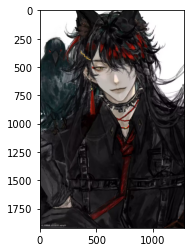

生成的文字: 
0 一 个 抱 着 小 孩 的 男 人 站 在 房 屋 前 的 道 路 上 [SEP] 一 个 人 的 前 面 [SEP] [SEP] [SEP]
1 一 个 大 腹 便 便 的 男 人 站 在 房 屋 前 的 道 路 上 [SEP] 一 个 人 的 前 面 [SEP] [SEP] [SEP]
2 一 个 大 腹 便 便 的 男 人 躺 在 房 屋 内 [SEP] [SEP] [SEP] 房 间 内 的 床 上 [SEP] [SEP] [SEP] [SEP] [SEP]
3 一 个 大 腹 便 便 的 男 人 躺 在 房 屋 里 [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] 噗 噗 噗 噗 ~ ~ [SEP] [SEP]
4 一 个 抱 着 小 孩 的 男 人 站 在 房 屋 前 的 道 路 上 [SEP] 一 个 穿 着 黑 色 衣 服 的


In [66]:
def cap_img(img_path: str, feature_extractor: CLIPFeatureExtractor, vision_model: CLIPVisionModel):
    model.eval()
    # 导入图片
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    print('你输入的图片: ')
    plt.imshow(img)
    plt.show()
    img = torch.from_numpy(img.transpose(2,0,1))
    
    # 图片预处理
    pixel_values = feature_extractor(img, return_tensors='pt')['pixel_values']
    img_feature = vision_model(pixel_values.to('cpu')).pooler_output.view(1, -1)

    # 生成文字
    print('生成的文字: ')
    model.text_gen = model.text_gen.to('cpu')
    model.device = 'cpu'
    model.fc = model.fc.to('cpu')
    generate(img_feature.to('cpu'), model.to('cpu'), tokenizer, max_length=30, num_samples=10)
device = 'cpu'
cap_img('./images/police.jpg', feature_extractor, vision_model)

In [ ]:
torch.save(model, './clipcap_mlp_finetune.model')